In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Canny
Usamos para detectar contornos y discriminar el resto. 
La implementación de OpenCV lo hace con dos thresholds que definen qué es un borde fuerte y qué es un borde débil.
> Los bordes fuertes se conservan siempre. Los bordes débiles se conservan si están unidos a bordes fuertes.

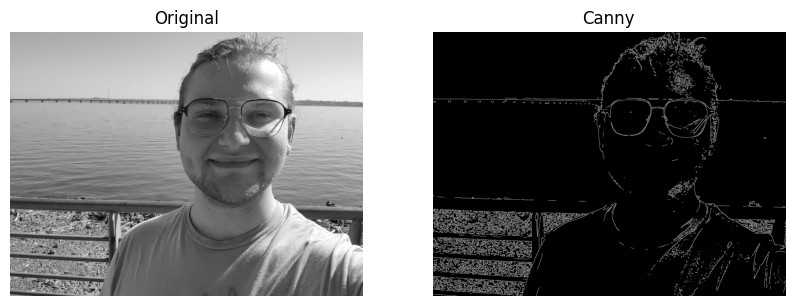

In [2]:
img = cv2.imread("images/yo.jpg", cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img, threshold1=200, threshold2=300)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("Canny")
plt.axis('off')

plt.show()

# ¿Qué pasa con la iluminación? ¿Y el contraste?
Como Canny usa la derivada (gradiente) para definir los contornos, contrastes bajos quieren decir que el máximo valor de ese gradiente va a ser más pequeño, por lo que habría que ajustar esos tresholds según el contraste.

Algo similar pasa con la iluminación, si la media de intensidad de los pixeles es pequeña, es *más probable* que los gradientes también bajen.

La manera más simple de tener en cuenta estos dos factores es justamente la media, una media baja indica iluminación y contraste más bajos, y una media alta suele indicar lo contrario.

ESTO ULTIMO ES FALSO, HAY QUE ANALIZAR EL HISTOGRAMA

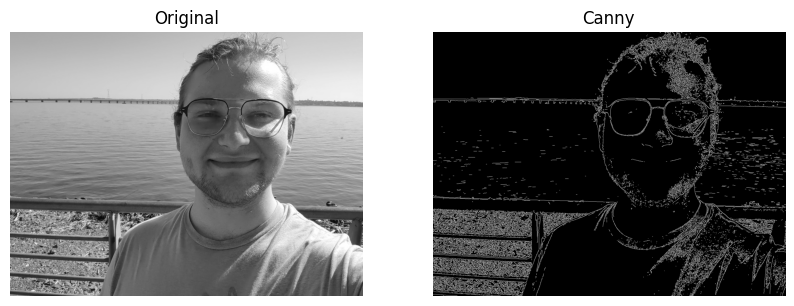

In [3]:
med = np.median(img)

sens = 0.1 #es qué tan separados de la media están los thresholds, acá los estamos ligando a la media

low_thresh  = int(max(0,  (1.0 - sens) * med))
high_thresh = int(min(255, (1.0 + sens) * med))

edges = cv2.Canny(img, low_thresh, high_thresh)


#mostrar imagen
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("Canny")
plt.axis('off')

plt.show()

In [4]:
#muestra con distintas imágenes
img_to_dark = cv2.imread("images/yo.jpg")
beta = -50
darker = cv2.convertScaleAbs(img_to_dark, alpha = 1.0, beta=beta)
# cv2.imwrite("yo_darker.jpg", darker)

In [5]:
def canny_auto_thresholds(img, sens):
    med = np.median(img)
    low_thresh  = int(max(0,  (1.0 - sens) * med))
    high_thresh = int(min(255, (1.0 + sens) * med))
    edges = cv2.Canny(img, low_thresh, high_thresh)
    return edges

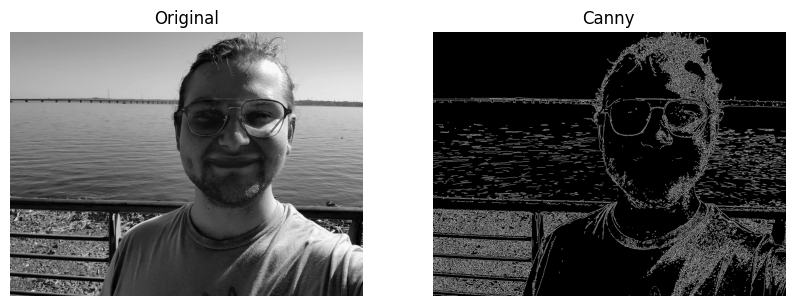

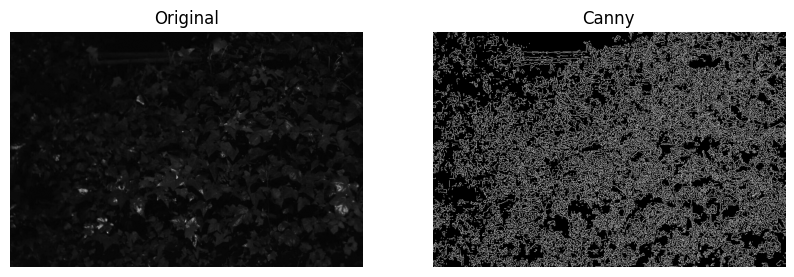

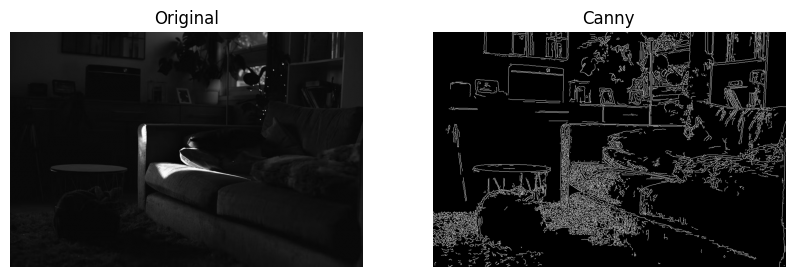

In [6]:
img1 = cv2.imread("images/yo_darker.jpg", cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("images/52350525926_4e43f03153_b.jpg", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("images/habitacion.jpg", cv2.IMREAD_GRAYSCALE)

imgs = [img1, img4, img3]
for i, img in enumerate(imgs):
    edges = canny_auto_thresholds(img, sens=0.2)
    
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny")
    plt.axis('off')

    plt.show()


# Problemas
- A veces cuando hay texturas (tierra, tela, etc) Canny detecta muchos bordes que no son relevantes.
- En la imagen que está toda oscura salvo una parte, canny detecta bien los bordes en la zona oscura, y detecta absurdamente muchos bordes en la zona clara.

### Probamos otras formas de mejorar la detección Canny

- Una forma es agregar un blur para matar inperfecciones
- Otra forma es ecualizar el espectro para detectar mejor
- Morfologia ? 

In [7]:
# 1. Preprocesamiento con desenfoque para reducir ruido/texturas
def canny_mejorado(img, sens=0.33, blur_kernel=5):
    # Aplicar desenfoque gaussiano para reducir ruido
    blurred = cv2.GaussianBlur(img, (blur_kernel, blur_kernel), 0)
    
    med = np.median(blurred)
    low_thresh  = int(max(0,  (1.0 - sens) * med))
    high_thresh = int(min(255, (1.0 + sens) * med))
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    
    return edges

# 2. Ecualización de histograma para zonas con iluminación desigual
def canny_ecualizado(img, sens=0.33):
    # Ecualizar histograma (CLAHE es mejor para iluminación local)
    clahe = cv2.createCLAHE(clipLimit=4.5, tileGridSize=(8,8))
    equalized = clahe.apply(img)
    
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    med = np.median(blurred)
    low_thresh  = int(max(0,  (1.0 - sens) * med))
    high_thresh = int(min(255, (1.0 + sens) * med))
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    
    return edges

# 3. Usar morfología para limpiar bordes
def canny_limpio(img, sens=0.33):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    med = np.median(blurred)
    low_thresh  = int(max(0,  (1.0 - sens) * med))
    high_thresh = int(min(255, (1.0 + sens) * med))
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    
    # Morfología para limpiar bordes pequeños
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    return edges

# 4. CLAHE mejorado: combinando ecualización + blur + morfología
def canny_clahe_mejorado(img, sens=0.33, clip_limit=2.0, tile_size=8, blur_kernel=5):
    # 1. CLAHE para ecualizar
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    equalized = clahe.apply(img)
    
    # 2. Blur para reducir ruido/texturas
    blurred = cv2.GaussianBlur(equalized, (blur_kernel, blur_kernel), 0)
    
    # 3. Canny con thresholds automáticos
    med = np.median(blurred)
    low_thresh  = int(max(0,  (1.0 - sens) * med))
    high_thresh = int(min(255, (1.0 + sens) * med))
    edges = cv2.Canny(blurred, low_thresh, high_thresh)
    
    return edges

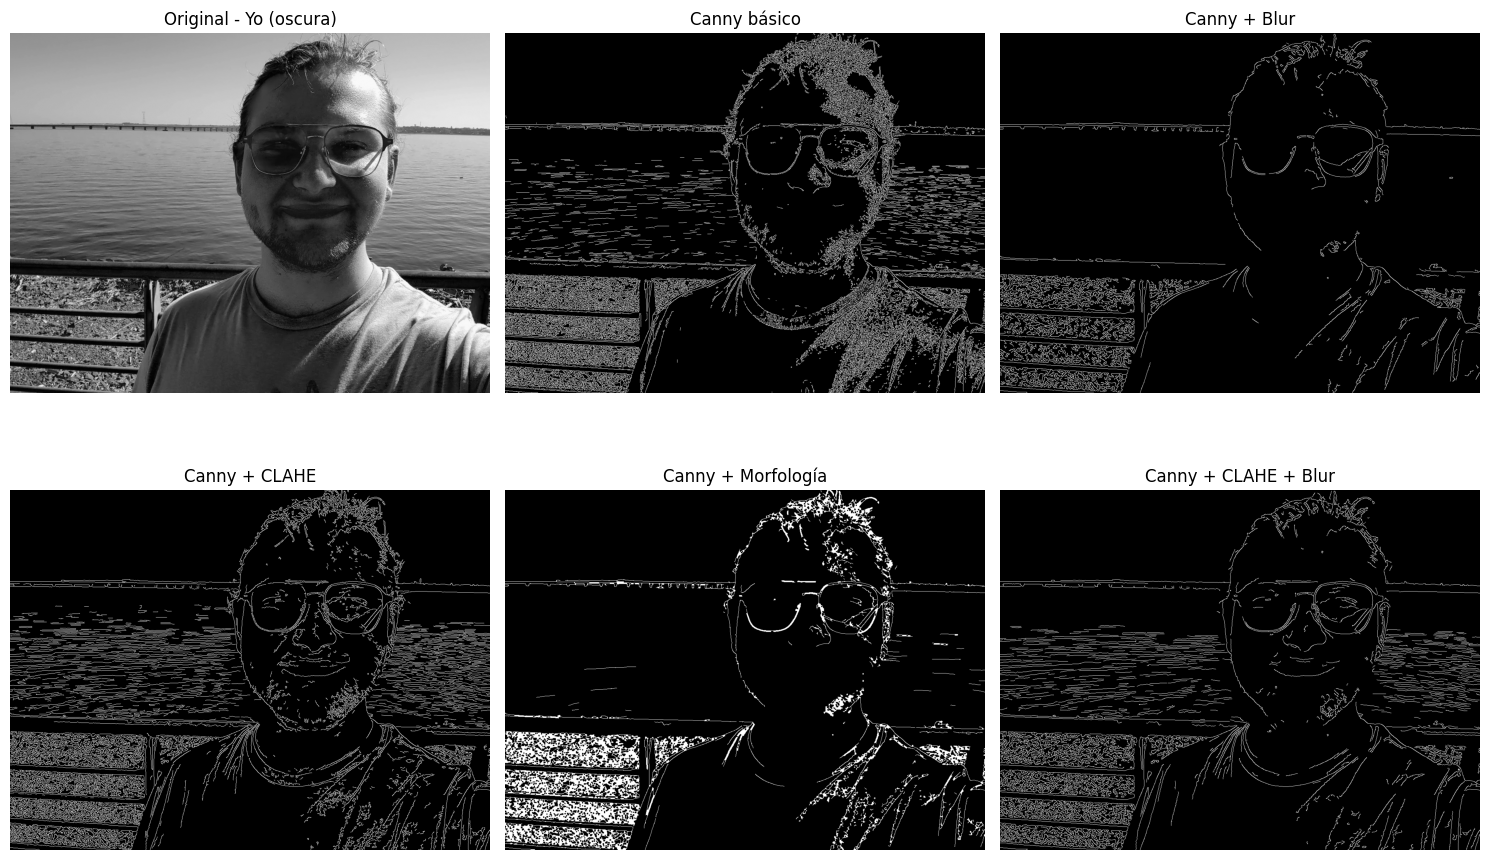

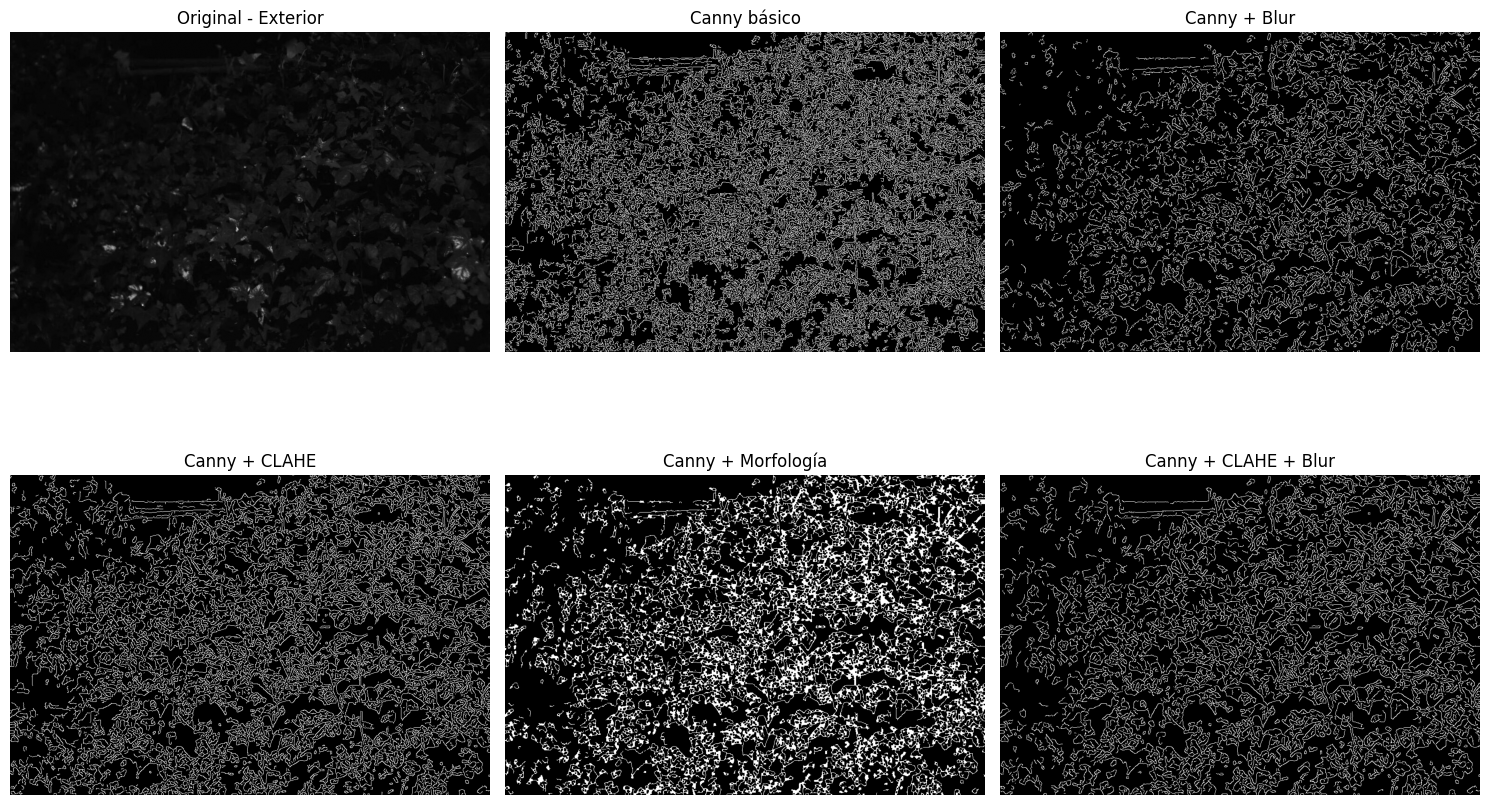

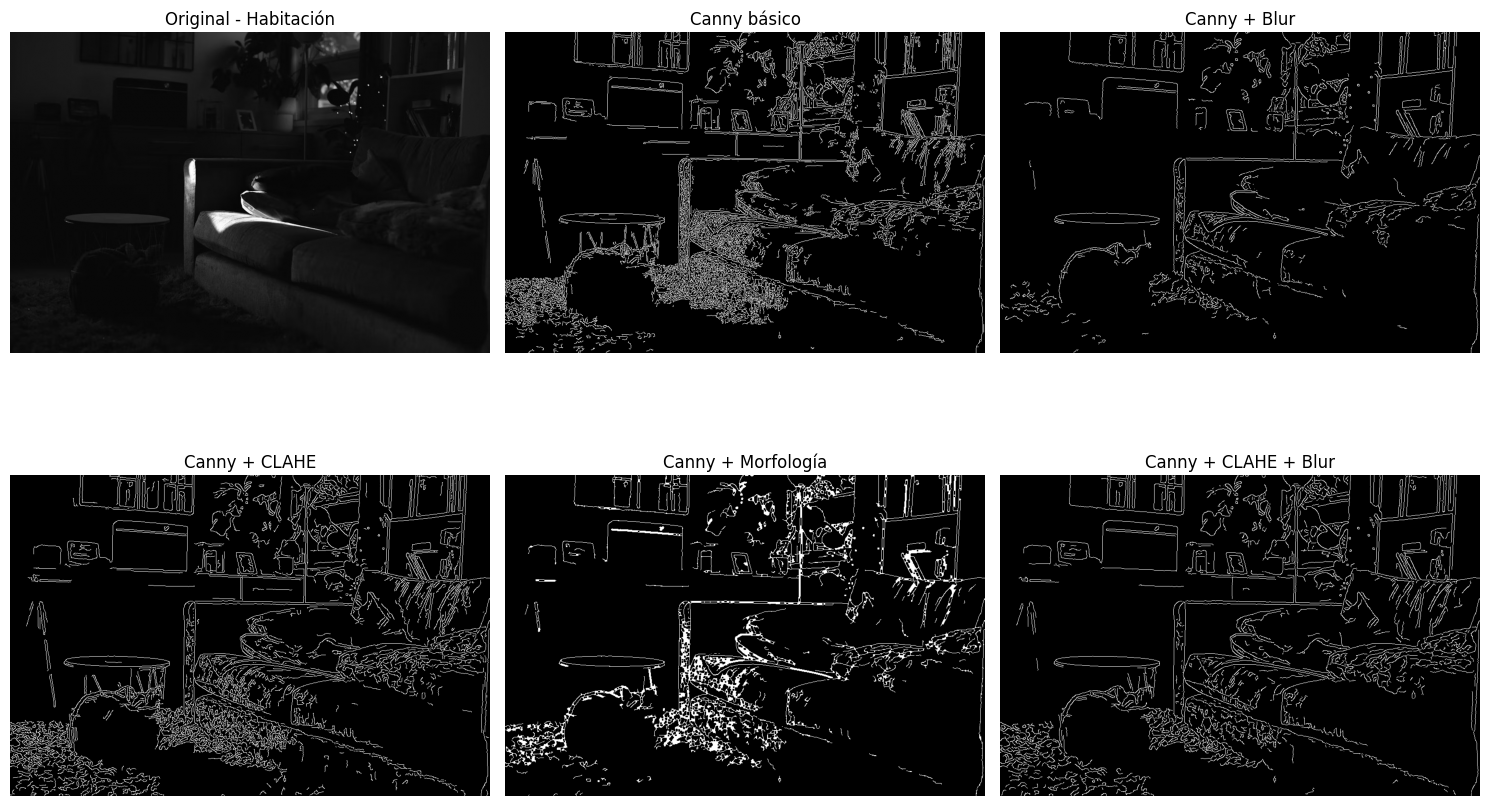

In [8]:
img1 = cv2.imread("images/yo_darker.jpg", cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread("images/52350525926_4e43f03153_b.jpg", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("images/habitacion.jpg", cv2.IMREAD_GRAYSCALE)

imgs = [img1, img4, img3]
titles_imgs = ["Yo (oscura)", "Exterior", "Habitación"]

for i, img in enumerate(imgs):
    # Aplicar las 4 funciones
    edges_original = canny_auto_thresholds(img, sens=0.3)
    edges_mejorado = canny_mejorado(img, sens=0.3, blur_kernel=7)
    edges_ecualizado = canny_ecualizado(img, sens=0.3)
    edges_limpio = canny_limpio(img, sens=0.3)
    calche_mejorado = canny_clahe_mejorado(img, sens=0.3, clip_limit=4.5, tile_size=8, blur_kernel=7)
    
    # Mostrar comparación
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original - {titles_imgs[i]}")
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(edges_original, cmap='gray')
    plt.title("Canny básico")
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(edges_mejorado, cmap='gray')
    plt.title("Canny + Blur")
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(edges_ecualizado, cmap='gray')
    plt.title("Canny + CLAHE")
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(edges_limpio, cmap='gray')
    plt.title("Canny + Morfología")
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(calche_mejorado, cmap='gray')
    plt.title("Canny + CLAHE + Blur")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()